In [69]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet, LassoCV, ElasticNetCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.neural_network import MLPRegressor
from utils.ml_utils import *

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import ParameterSampler
from tqdm import tqdm

from data_prep import load_features_data
from sklearn.feature_selection import RFECV, SelectFromModel
from sklearn.model_selection import TimeSeriesSplit



**Load the features data, these are popular trend following features used in prior literature, this notebook assumes you have the pickle file residual_returns.pkl saved in the root directory, you can download this file from the OneDrive**

In [70]:
feats = load_features_data()
feats.tail()

ret      rVol    1d_ret   1wk_ret    1m_ret  \
date       cluster                                                      
2024-03-15 25        4.383299  0.012166 -0.017495 -0.027395 -0.000720   
           26        2.462165  0.012035 -0.001765  0.009387  0.015050   
           27        2.082460  0.012796 -0.035808 -0.060372 -0.092488   
           28       10.425301  0.012590 -0.011795  0.038502  0.142882   
           29        1.745186  0.012396 -0.012951 -0.018736  0.068956   

                      1Q_ret    6M_ret   12M_ret  feature_1d_ra  \
date       cluster                                                
2024-03-15 25       0.102992  0.072872  0.146811      -1.438042   
           26      -0.022086  0.025308 -0.005369      -0.146644   
           27      -0.037253  0.112426  0.139470      -2.798448   
           28       0.110394  0.209679  0.370151      -0.936814   
           29       0.007108 -0.013731 -0.046507      -1.044764   

                    feature_1wk_ra  ...  lag5_feature_MACD_short  \
date       cluster                  ...                            
2024-03-15 25            -1.007008  ...                 0.398363   
           26             0.348834  ...                -0.199871   
           27            -2.110060  ...                -0.032563   
           28             1.367633  ...                 0.523603   
           29            -0.675943  ...                 0.626469   

                    lag5_feature_MACD_medium  lag5_feature_MACD_long  \
date       cluster                                                     
2024-03-15 25                       0.585645                0.664800   
           26                      -0.179508                0.128255   
           27                       0.246765                0.754907   
           28                       0.554301                0.698447   
           29                       0.518373                0.183227   

                    lag5_feature_skew6m  lag5_feature_skew12m  \
date       cluster                                              
2024-03-15 25                 -0.222085              0.386809   
           26                 -0.217538              0.392190   
           27                 -0.231616              0.380269   
           28                 -0.231386              0.365261   
           29                 -0.230371              0.372743   

                    lag5_feature_kurt6m  lag5_feature_kurt12m  fwd_ret1d  \
date       cluster                                                         
2024-03-15 25                  0.580919              2.809109        NaN   
           26                  0.566987              2.789701        NaN   
           27                  0.525654              2.751046        NaN   
           28                  0.518548              2.752472        NaN   
           29                  0.519866              2.848368        NaN   

                    target  targetBin  
date       cluster                     
2024-03-15 25          NaN        NaN  
           26          NaN        NaN  
           27          NaN        NaN  
           28          NaN        NaN  
           29          NaN        NaN  

[5 rows x 89 columns]

count    174209.000000
mean          0.031924
std           1.285065
min         -19.381877
25%          -0.646536
50%           0.065431
75%           0.736927
max          16.556220
Name: target, dtype: float64


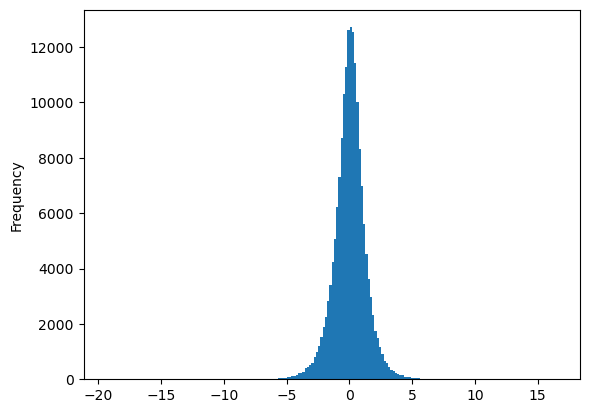

In [71]:
# distribution of tragets
feats['target'].plot(kind='hist', bins=200)
print(feats['target'].describe())

**Extract the predictive features and target, which is one day forward risk adjusted return - drop na on this subset**

In [72]:
features = [f for f in feats.columns if f.startswith("feature")]
target = ["target"]
lag_feats = [f for f in feats.columns if f.startswith('lag')]

all_feats = features + target + lag_feats
feats.dropna(subset=all_feats, inplace=True)
feats = feats[all_feats]

print("Shape of features", feats.shape)

Shape of features (166530, 79)


**Break out X and y and set up cross-validation, define models**

In [73]:
X = feats[all_feats].copy()

# set some configs
N_ITER=1

# Random Forest Regressor
baseRF = RandomForestRegressor(max_depth=5, 
                               n_estimators=1000,
                               max_features=int(1),
                               random_state=49, 
                               n_jobs=-3)

# simple-grid
grid = {'rf__n_estimators': np.arange(100, 1000, 100),
        'rf__max_depth': [3, 6, 9, 12],
        'rf__max_features': [int(1), 'sqrt'],
        'rf__min_weight_fraction_leaf': np.arange(0.0, 0.05, 0.005)}
paramsRF = ParameterSampler(n_iter=N_ITER, param_distributions=grid)

rfPipe = Pipeline(steps=[('scaler', RobustScaler()),
                        ('selector', SelectFromModel(estimator=ElasticNetCV(), threshold=0.)),
                        ('rf',baseRF)])

# Elastic Net Regressor
net = ElasticNet()
eNetPipe = Pipeline(steps=[('scaler', RobustScaler()), ('net', net)])
eNet_grid = {'net__alpha': [.000001, .00001, .0001, .001, .01, .10, 1.],
             'net__l1_ratio': np.arange(.05, 1., .05),
             'net__tol': [1e-2, 1e-3, 1e-4, 1e-5, 1e-6]}
paramsNet = ParameterSampler(n_iter=N_ITER, param_distributions=eNet_grid)

# MLP Regressor
mlp = MLPRegressor(hidden_layer_sizes=(8, 4),
                   random_state=49,
                   shuffle=True,
                   max_iter=500,
                   early_stopping=False,
                   learning_rate='adaptive')

mlp_pipe = Pipeline(steps=[('scaler', RobustScaler()),
                           ('selector', SelectFromModel(estimator=ElasticNetCV(), threshold=0.)),
                           ('mlp', mlp)])
mlp_grid = {'mlp__learning_rate_init': [.000001, .00001, .0001, .001, .01, .10],
            'mlp__batch_size': [16, 32, 64, 128, 256],
            'mlp__alpha': [.000001, .00001, .0001, .001, .01, .10]}
mlp_sampler = ParameterSampler(n_iter=N_ITER, param_distributions=mlp_grid)

models = [(rfPipe, paramsRF, 'preds_RandomForest'),
          (eNetPipe, paramsNet, 'preds_ElasticNet'),
          (mlp_pipe, mlp_sampler, 'preds_MLP')]


**Form the training loop, here we train on 3 year expanding windows, using 90% of each split for training and 10% for tuning hyper-parameters, we then use the same model to forecast forward 3-years before re-training again.**

In [74]:
def train_single_model(model, sampler, model_name):
    predictions = []
    scores = []
    for train, test in tqdm(get_cv_splits(X, split_length=252*5)):
        # break out X and y train, test
        X_train, y_train = train[features], train[target] 
        X_test, y_test = test[features], test[target]

        # hyper-param loop
        X_train2, X_val, y_train2, y_val = train_val_split(X_train, y_train)
        print(X_train2.shape, X_val.shape)

        # inner loop for parameter tuning
        gscv_scores = {'scores': [], 'grid':[]}
        for k, p in enumerate(sampler):
            model.set_params(**p)
            try:
                model.n_jobs=-1
            except Exception as e:
                pass
            model.fit(X_train2, y_train2.values.reshape(y_train2.shape[0], ))
            _pred = model.predict(X_val)
            _score = mean_squared_error(y_val, _pred)
            gscv_scores['scores'].append(_score)
            gscv_scores['grid'].append(p)
            print(f'Iter: {k}: Score: {_score}')

        # now fit the best model
        best_model = pd.DataFrame(gscv_scores).sort_values(by='scores').head(1)['grid'].values[0]
        print(best_model)
        best_model = model.set_params(**best_model)
        best_model.n_jobs=-1
        best_model.fit(X_train, y_train.values.reshape(y_train.shape[0], ))
        preds = best_model.predict(X_test)

        # append the predictions
        predictions.append(pd.Series(index=y_test.index, data=preds))

        # score
        scores.append(mean_squared_error(y_test, preds))

    # predictions
    predictions = pd.concat(predictions).to_frame(model_name)
    return predictions

# train all models selected
predictions = []
for model in models:
    out = train_single_model(model[0], model[1], model[2])
    predictions.append(out)

# concat the predictions by columns
predictions = pd.concat(predictions, axis=1)

0it [00:00, ?it/s]

4
(34047, 13) (3780, 13)
Iter: 0: Score: 1.8060454116200102
{'rf__n_estimators': 300, 'rf__min_weight_fraction_leaf': 0.005, 'rf__max_features': 'sqrt', 'rf__max_depth': 3}


1it [00:02,  2.71s/it]

(68094, 13) (7560, 13)
Iter: 0: Score: 1.9027832075250921
{'rf__n_estimators': 700, 'rf__min_weight_fraction_leaf': 0.02, 'rf__max_features': 'sqrt', 'rf__max_depth': 3}


2it [00:12,  6.73s/it]

(102114, 13) (11340, 13)
Iter: 0: Score: 1.49881105587062
{'rf__n_estimators': 500, 'rf__min_weight_fraction_leaf': 0.0, 'rf__max_features': 1, 'rf__max_depth': 3}


3it [00:16,  5.79s/it]

(136134, 13) (15120, 13)
Iter: 0: Score: 1.5255679298609812
{'rf__n_estimators': 500, 'rf__min_weight_fraction_leaf': 0.015, 'rf__max_features': 'sqrt', 'rf__max_depth': 6}


4it [00:43, 10.79s/it]
0it [00:00, ?it/s]

4
(34047, 13) (3780, 13)
Iter: 0: Score: 1.784341973792938
{'net__tol': 1e-05, 'net__l1_ratio': 0.8500000000000001, 'net__alpha': 0.01}
(68094, 13) (7560, 13)


2it [00:00,  3.76it/s]

Iter: 0: Score: 1.9087671210540436
{'net__tol': 0.0001, 'net__l1_ratio': 0.45, 'net__alpha': 0.0001}


3it [00:00,  4.17it/s]

(102114, 13) (11340, 13)
Iter: 0: Score: 1.5010489651107017
{'net__tol': 0.01, 'net__l1_ratio': 0.6000000000000001, 'net__alpha': 0.0001}
(136134, 13) (15120, 13)


4it [00:00,  4.44it/s]


Iter: 0: Score: 1.5242499763134592
{'net__tol': 0.01, 'net__l1_ratio': 0.6000000000000001, 'net__alpha': 0.01}


0it [00:00, ?it/s]

4
(34047, 13) (3780, 13)
Iter: 0: Score: 1.8123748026039896
{'mlp__learning_rate_init': 0.01, 'mlp__batch_size': 256, 'mlp__alpha': 0.01}


1it [00:04,  4.22s/it]

(68094, 13) (7560, 13)
Iter: 0: Score: 1.899545670921844
{'mlp__learning_rate_init': 1e-05, 'mlp__batch_size': 16, 'mlp__alpha': 1e-06}


2it [00:43, 24.96s/it]

(102114, 13) (11340, 13)
Iter: 0: Score: 1.5186203443030482
{'mlp__learning_rate_init': 0.01, 'mlp__batch_size': 16, 'mlp__alpha': 1e-05}


3it [01:54, 45.81s/it]

(136134, 13) (15120, 13)
Iter: 0: Score: 1.563256930351783
{'mlp__learning_rate_init': 0.001, 'mlp__batch_size': 16, 'mlp__alpha': 0.0001}


4it [03:25, 51.39s/it]


**Check distribution of the targets**

<Axes: title={'center': 'distribution of predictions'}, ylabel='Frequency'>

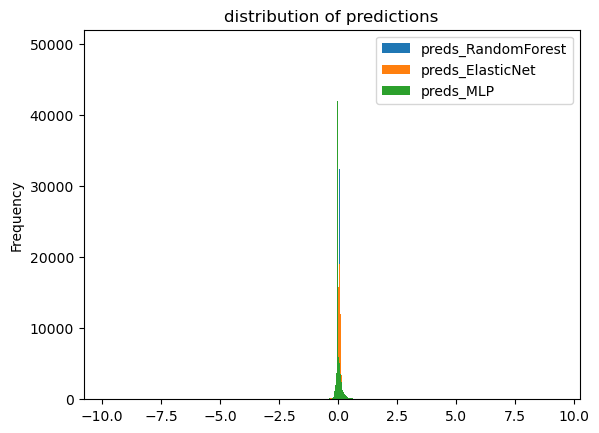

In [75]:
# We can see predictions go negative at about the 25% percentile, market mainly goes up
predictions.plot(kind='hist', bins=1000, title="distribution of predictions")

**Join in predictions with the original dataset which has the cluster returns**

In [76]:
# bring in the data
data = load_features_data()

# join in predictions
predictions = predictions.merge(data, how="left", left_index=True, right_index=True)
predictions.sort_index(inplace=True)

# get the prediction columns
pred_cols = [f for f in predictions.columns if f.startswith('preds_')]

def getRetsForStrat(predictions, pred_cols):
    ret_list = []
    for pred_col in pred_cols:
        predictions[f'{pred_col}_signalQ'] = predictions.groupby(by='date')[pred_col].apply(lambda x: pd.qcut(x, 4, labels=False, duplicates='drop')).droplevel(0)
        predictions[f'{pred_col}_signalQ'] = predictions.groupby(by='cluster')[f'{pred_col}_signalQ'].shift(1)

        rets = predictions.groupby(by=['date', f'{pred_col}_signalQ'])['1d_ret'].mean().unstack()
        rets.rename(columns={col: f'{pred_col}_Q_{col}' for col in rets.columns}, inplace=True)
        ret_list.append(rets)
    return ret_list

ret_breakouts = []
# get all the returns
all_rets = getRetsForStrat(predictions, pred_cols)
for one_ret in all_rets:
    print(get_returns_breakout(one_ret))
    ret_breakouts.append(get_returns_breakout(one_ret))
    print('#################################')

# stack the returns
stacked_strat_rets = pd.concat([r.stack().to_frame('ret') for r in all_rets]) # this can hopefully be the data used for streamlit
stacked_strat_rets_cumprod = (1+stacked_strat_rets.unstack()).cumprod()

# save to pickle
stacked_strat_rets_cumprod.columns = stacked_strat_rets_cumprod.columns.droplevel(0)
stacked_strat_rets_cumprod.to_pickle("cum_cluster_returns.pkl")
pd.concat(ret_breakouts).to_pickle("metrics_df.pkl")

                         Annual_Return Annual_Volatility        DD       MDD  \
preds_RandomForest_Q_0.0      0.067933          0.235349  0.169079 -0.608103   
preds_RandomForest_Q_1.0      0.068361          0.239596  0.170999 -0.598345   
preds_RandomForest_Q_2.0      0.046776          0.236829  0.169745 -0.609168   
preds_RandomForest_Q_3.0      0.064493          0.238612  0.171288 -0.590003   

                            Sharpe   Sortino    Calmar ppct_postive_rets  
preds_RandomForest_Q_0.0   0.39761   0.55345  0.111713          0.534064  
preds_RandomForest_Q_1.0  0.396319  0.555305  0.114249          0.541297  
preds_RandomForest_Q_2.0  0.311924  0.435197  0.076787          0.531031  
preds_RandomForest_Q_3.0  0.381865  0.531956  0.109309          0.536398  
#################################
                       Annual_Return Annual_Volatility        DD       MDD  \
preds_ElasticNet_Q_0.0      0.055562          0.235762  0.169582 -0.606183   
preds_ElasticNet_Q_1.0      0.0890

ValueError: Length mismatch: Expected axis has 1 elements, new values have 12 elements